## Imports

In [2]:
import sys
import os
repo_path = os.path.abspath('../')
sys.path.append(repo_path)
import scripts.addSA2 as addSA2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geoplot.crs as gcrs
import geopandas as gpd
import geoplot as gplt
import pandas as pd

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import f_regression, SelectKBest


from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import statistics as stat
from sklearn.model_selection import cross_val_score

## Data Download

The first thing we need to do is download the datasources needed for our analysis.

(see data_download.py in the script folder for details)

(Run this script if data download not previously run)

In [3]:
%run ../scripts/data_download.py

INFO:root:Beginning zone download
INFO:root:Finished zone download
replace ../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
INFO:root:Beginning population download


Archive:  ../data/raw/abs_data/zone_data/zones.zip


INFO:root:Finished population download
INFO:root:Beginning income download
INFO:root:Finished population download
INFO:root:Beginning population projection download
INFO:root:Finished population projection download
INFO:root:Beginning school download
INFO:root:Finished school download
INFO:root:Beginning postcode download
INFO:root:Finished postcode download


## Scraping

For this project we decided to scrape rental data from domain.com.au.
This website has a huge number of listings, and by searching by postcode we collected a large number of metrics from each listed property.

This process is done in scrape.ipynb, and the results are saved in the raw data folder. as scraped_properties.csv as seen below.
(This will not be run in this notebook as it takes an extremely long time)

In [4]:
scraped = pd.read_csv(f"../data/raw/scraped_properties.csv")

,url,price,address,num_beds,num_bath,num_car,property_type,agent,bond,internal_area,...,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_average_age,demographic_owner,demographic_renter,demographic_family,demographic_single,latitude,longitude
0,https://www.domain.com.au/40-esmond-street-ard...,$400,40 Esmond Street Ardeer VIC 3022,3 Beds,2 Baths,1 Parking,House,Create Vic Real Estate,Bond $1738,NaN,...,Sold this year: 37,Avg days on market: 44,"Population: 3,099",Average age: 20 to 39,67%,33%,41%,59%,-37.775134,144.797067
1,https://www.domain.com.au/11-grant-avenue-gisb...,$600.00,11 Grant Avenue Gisborne VIC 3437,4 Beds,2 Baths,1 Parking,House,Brad Teal Woodards Gisborne,Bond $2608,NaN,...,Sold this year: 92,Avg days on market: 41,"Population: 9,000",Average age: 40 to 59,83%,17%,58%,42%,-37.493363,144.595569
2,https://www.domain.com.au/15-balmoral-avenue-b...,$575,15 Balmoral Avenue Bundoora VIC 3083,3 Beds,1 Bath,3 Parking,House,Thomas Quixley Fairfield Pty Ltd,Bond $2499,NaN,...,Sold this year: 229,Avg days on market: 52,"Population: 28,681",Average age: 20 to 39,72%,28%,47%,53%,-37.707414,145.065424


## API Data

Now we get a bunch of distance data for various properties that we can merge into our other data

This is done with the school_proximities.ipynb notebook. But is quite an involved process, so that data is saved inside the git repository instead of being run here.

## Pre-Processing

While this gives us a lot of raw data, it needs to be put into a useable format first. This is done in pre_processing.py. By using a variety of regex rules to extract the relevant numbers from the data. We also need to remove a specific NSW town that was caught in the scrape for some reason. We also remove carspaces as they are not relevant to the problems.

From there we merge with the API distance data that has been gathered, and remove outliers based on cook's distance in a linear regression model.

(run this script if pre-processing notebook not run)

In [ ]:
%run ../scripts/pre_processing.py

Now our data looks like this:

In [3]:
pre_processed = pd.read_csv(f"../data/curated/pre_processed_data.csv")
display(pre_processed.head(3))

,url,postcode,suburb,state,weekly_rent,bond,num_beds,num_baths,num_parking,property_type,...,park_distance,shop_duration,shop_distance,train_duration,train_distance,stop_duration,stop_distance,SA2,population,median_weekly_income
0,https://www.domain.com.au/4-12-maylands-street...,3020,albion,vic,400.0,1738.0,2.0,2.0,1.0,Apartment / Unit / Flat,...,717.5,2.571667,1577.0,2.106667,1215.7,0.71,532.1,213011328.0,7595,704
1,https://www.domain.com.au/5-44-adelaide-street...,3020,albion,vic,280.0,1218.0,2.0,1.0,1.0,Townhouse,...,301.2,2.756667,1371.8,2.225000,846.1,0.68,308.6,213011328.0,7595,704
2,https://www.domain.com.au/10-84-rockbank-rd-ar...,3022,rockbank,vic,375.0,1630.0,2.0,1.0,1.0,House,...,246.1,8.535000,5810.5,5.161667,2717.6,1.26,539.5,213011328.0,7595,704


We can also add in the SA2 zone and corresponding geometry for each of these listings. This allows us to visualise the data in various ways.

In [4]:
sa2_grouped = addSA2.addSA2(pre_processed, use_postcode=False)
sa2_grouped = sa2_grouped.groupby("SA2").mean().reset_index()

shape = gpd.read_file('../data/raw/ShapeFile/SA2_2021_AUST_GDA2020.shp')
shape = shape.loc[shape.STE_NAME21 == "Victoria"]
shape = shape.loc[shape.geometry != None]
shape["SA2_CODE21"] = pd.to_numeric(shape["SA2_CODE21"], errors='ignore')
sa2_grouped = gpd.GeoDataFrame(sa2_grouped.join(shape.set_index("SA2_CODE21")["geometry"], on="SA2"))
sa2_grouped = sa2_grouped[sa2_grouped["geometry"] != None]

If you want to see a plot of any feature, simply type the feature into the "FEATURE HERE" section below:

<AxesSubplot:>

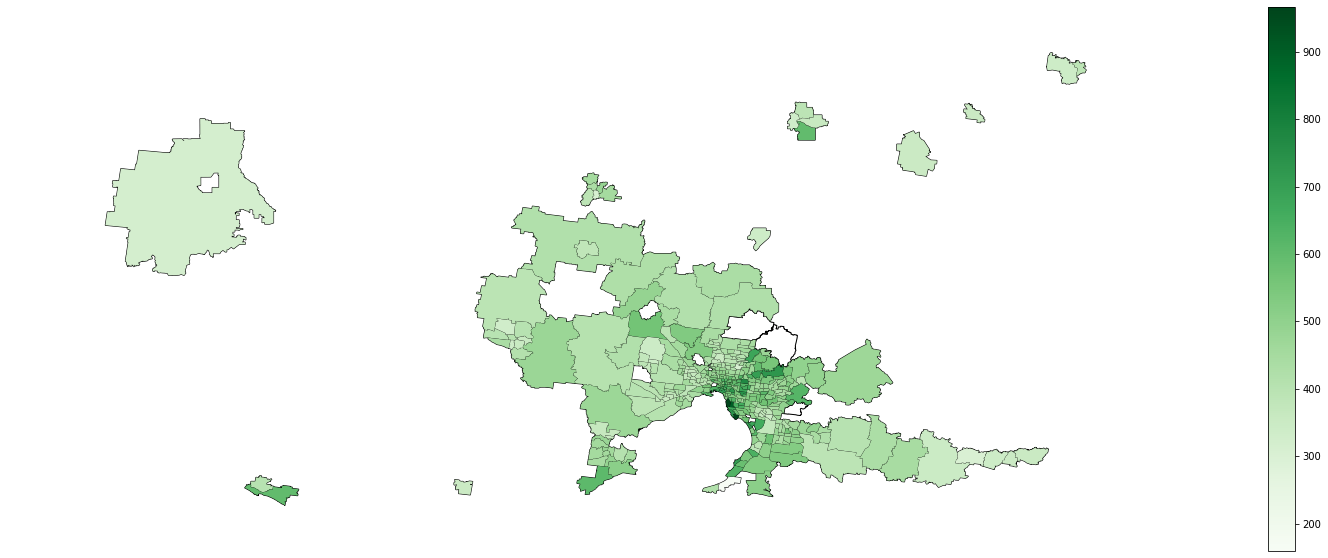

In [8]:
# Plot the lines for the visualisation
ax = gplt.polyplot(sa2_grouped, figsize=(30, 10))
# create a heatmap based on a particular feature
gplt.choropleth(
  sa2_grouped,
  hue="FEATURE HERE",
  edgecolor="black",
  linewidth=0.1,
  cmap="Greens",
  legend=True,
  ax=ax
)

## Question 1
Using the grouped suburb data we try to predict suburb's rent based on features previously gathered

### Read in data

In [ ]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

DIR_CUR = "../data/curated/"
DIR_PLT = "../plots/"

In [ ]:
# read in suburb level version of data
df = pd.read_csv(f"{DIR_CUR}suburb_data.csv")
display(df.head(3))

## Finding Most important features in predicting Rent
Using the F-score we find the 3 features of the suburb data to have the strongest predictive power to the median rent.

In [ ]:
df_clean = df.drop(["suburb", "bond", "internal_area", "land_area"], axis=1)
df_clean = df_clean.dropna().reset_index(drop=True)

K_BEST = 3

X = df_clean.drop(["weekly_rent"], axis=1)
y = df_clean["weekly_rent"]

selector = SelectKBest(f_regression, k=K_BEST)
selector.fit_transform(X, y)
features_index = selector.get_support(indices=True)
predictors = list(X.iloc[:,features_index].columns)

print("The most important features are:")
for predictor in predictors:
    print(f"* {predictor}")

## Plots VS the weekly rent

In [ ]:
def vs(x, y, x_lab, y_lab, title, x_trans=lambda x: x, y_trans=lambda x: x):
    """creates a scatter plot between x and y"""
    plt.scatter(x_trans(x), y_trans(y), color="#fad051")
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=16)
    plt.ylabel(y_lab, size=16)
    plt.show()

vs(df["school_distance"], df["weekly_rent"], "School Distance (m)", "Weekly Rent (AUS)", "Weekly Rent vs School Distance")
vs(df["median_weekly_income"], df["weekly_rent"], "Weekly Income (AUS)", "Weekly Rent (AUS)", "Weekly Rent vs Weekly Income")
vs(df["performance_median_price"], df["weekly_rent"], "Price (AUS)", "Weekly Rent (AUS)", "Weekly Rent vs Price")

### Modeling using the 3 most important features
A Linear Regression and Multi-Layer Perceptron Regressor are fitted between rent and the 3 best features identified above 

In [ ]:
response = "weekly_rent"
scoring = "r2"

FOLDS = 8

def test_model(model, X, y):
    """Applys an 8-cross fold validation finding the R^2 for each fold"""
    scores = cross_val_score(model, X, y, scoring=scoring, cv=FOLDS)
    print(f"Min R^2:    {min(scores):.3f}")
    print(f"Max R^2:    {max(scores):.3f}")
    print(f"Median R^2: {stat.median(scores):.3f}")
    print(f"Mean R^2:   {stat.mean(scores):.3f}")

response = "weekly_rent"
predictors = ["median_weekly_income", "performance_median_price"] 

df_na_out = df.dropna(subset=predictors)

df_na_out = df.dropna(subset=predictors + [response]).reset_index(drop=True)

trans = ColumnTransformer(transformers=[("scale", StandardScaler(), predictors)]) 
X = trans.fit_transform(df_na_out[predictors])
y = df_na_out["weekly_rent"]

print("Linear Regression:")
test_model(LinearRegression(), X, y)

print("\nMulti-Layer Perceptron Regressor:")
test_model(MLPRegressor(random_state=30027, max_iter=1000000, n_iter_no_change=15), X, y)

## Question 2

For this question we need historical data instead of current, data. This has been scraped from domain.com.au, and is pre-processed seperately. (See predict_future_preprocess.ipynb for details)

(run this script if predict_future_preprocessing.ipynb notebook not run)

In [ ]:
%run ../scripts/predict_future_preprocessing.py

We originally tried fitting a linear regression model, but this gave poor performance, so we used an approach using predictor metrics instead.

## Predictor Metrics:

* Historical 3-year-growth: While a regression to the mean is fairly likely in many cases, a suburb having a high growth rate in previous years should still indicate that that is more likely to continue.

* Current growth rate: Extrapolating the 2022 growth rate to a 3 year prediction is unlikely to be accurate, but it is once again a decent indicator.

* New dwellings / population: If there is a high number of new dwellings relative to the population, then in theory the increased supply will lead to decreased house value.

* non residential value: The theory behind using this metric, is that non-residential housing indicates an increase in local business. This should in theory increase the value of the area. This may be incorrect, as it might indicate a non-residential area, but not sure.

* Clearance: A high clearance rate should indicate a high demand in the area, so in theory an increase in future prices.

* Average days on market: A low number of days on the market, should indicate (like clearance), a high demand for houses in the area.

* sold / population: If there are a high number of sales relative to the population it indicates market interest.

* Unfortunately due to a lack of historical data for many areas, and many of these metrics, we will have to decide aribtrarily on the importance of each feature. I will then create a ranking of each feature and use this as the input for the algorithm.

https://propertyupdate.com.au/property-investment-melbourne/#is-it-the-right-time-to-get-into-the-melbourne-property-market

https://www.trilogyfunding.com.au/blog/7-key-market-indicators-every-property-investor-should-understand-april-2015/


https://www.mmj.com.au/resources/blog/5-key-market-indicators-every-property-investor-should-know/

In [10]:
df = pd.read_csv(f"../data/curated/future_prediction_data.csv")

# Get rankings for each feature
predict_df = pd.DataFrame()
predict_df["suburb"] = df["suburb"]
predict_df["avg_days_on_market"] = df["avg_days_on_market"].rank(ascending = False) # low is better
predict_df["3_year_growth"] = df["3_year_growth"].rank(ascending = True) # high is better
predict_df["2022_growth"] = df["2022_growth"].rank(ascending = True) # high is better
predict_df["sold/pop"] = (df["2022_n_sold"]/df["suburb_population"]).rank(ascending = True).fillna(0) # high is better
predict_df["dwellings/pop"] = (df["new_dwellings_2021"]/df["suburb_population"]).rank(ascending = False).fillna(0) # low is better
predict_df["non_residential_value"] = df["non_residential_value_2021"].rank(ascending = True) # higher is better
predict_df["clearance"] = df["clearance"].rank(ascending = True) # higher is better
predict_df["sum"] = predict_df.sum(axis=1)
predict_df["SA2"] = df["SA2"]

/tmp/ipykernel_78/3970158553.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  predict_df["sum"] = predict_df.sum(axis=1)


In [11]:
predict_df = predict_df.sort_values(by="sum", ascending=False)
predict_df.to_csv(f"../data/curated/prediction_results.csv")

In [12]:
display(predict_df)

,suburb,avg_days_on_market,3_year_growth,2022_growth,sold/pop,dwellings/pop,non_residential_value,clearance,sum,SA2
402,flinders,907.0,1172.0,1175.0,132.0,262.0,1190.0,1188.5,6026.5,203021043.0
119,blairgowrie,452.0,1176.0,1116.0,450.0,162.5,1031.0,1154.0,5541.5,214021383.0
1068,tootgarook,489.0,1097.0,1142.0,453.0,162.5,958.0,1060.5,5362.0,214021383.0
681,mccrae,402.0,1170.0,997.0,333.0,205.0,1052.0,1181.0,5340.0,202011018.0
729,mornington,435.0,1042.0,889.0,399.0,289.0,1115.0,1161.0,5330.0,213051582.0
...,...,...,...,...,...,...,...,...,...,...
815,nungurner,907.0,322.5,280.0,0.0,0.0,363.0,436.5,2309.0,NaN
1195,yuroke,907.0,322.5,280.0,0.0,0.0,363.0,436.5,2309.0,NaN
367,elmore,7.0,322.5,280.0,151.0,81.0,894.0,436.5,2172.0,207011147.0
1188,yarrambat,9.0,322.5,280.0,637.5,0.0,363.0,436.5,2048.5,NaN


We can then see the ranking of suburbs. Flinders, Blairgowrie, tootgarook, mccrae, and mornington take the top spots.

In [16]:
shape = gpd.read_file('../data/raw/ShapeFile/SA2_2021_AUST_GDA2020.shp')
shape = shape.loc[shape.STE_NAME21 == "Victoria"]
shape = shape.loc[shape.geometry != None]
shape["SA2_CODE21"] = pd.to_numeric(shape["SA2_CODE21"], errors='ignore')
plot_df = predict_df.join(shape[["SA2_CODE21", "geometry"]].set_index("SA2_CODE21"), on="SA2")
plot_df = plot_df[plot_df["geometry"] != None]

In [ ]:
from matplotlib.pyplot import figure
import geoplot.crs as gcrs


ax = gplt.polyplot(shape, figsize=(100, 50))#, projection=gcrs.AlbersEqualArea())

gplt.choropleth(
  gpd.GeoDataFrame(plot_df),
  hue="sum",
  edgecolor="black",
  linewidth=0.1,
  cmap="Greens",
  legend=True,
  ax=ax
)

This graphic shows the results per SA2 zone, but because they don't line up with the suburbs very well, so we get a lot of missing values.

## Question 3

We start off by reading the data. We'll be using the processed dataset with *ptv*, *parks*, *schools*, and *shopping centres* proximity addded. Note that we'll be using the average proximity here

In [4]:
import pandas as pd
from pyrosm import OSM, get_data
import ssl
from scipy.stats import percentileofscore
import numpy as np
import geopandas as gpd
import folium
import sys
sys.path.append("../scripts")
from liveability_helper import median_rent, score

property_df = pd.read_csv(
    "/Users/matthewrush/Documents/generic-real-estate-consulting-project-group-32/data/curated/pre_processed_data.csv",
    usecols=[
        "url",
        "postcode",
        "school_duration",
        "school_distance",
        "park_duration",
        "park_distance",
        "shop_duration",
        "shop_distance",
    ],
)

postcode_df = pd.read_csv(
    "../data/raw/postcode.csv",
    usecols=["postcode", "locality"],
)

api_df = pd.read_csv(
    "../data/curated/api_data.csv",
    usecols=[
        "url",
        "train_duration",
        "train_distance",
        "stop_duration",
        "stop_distance",
    ],
)

historical_df = pd.read_csv(
    "../data/curated/historical_sales.csv",
    usecols=["postcode", "n_sold", "median_rent"],
)

property_df = pd.merge(property_df, api_df)
property_df = property_df.groupby("postcode").mean().reset_index()


Now we find the median rent of each suburb using the scraped data

In [5]:
property_df["median_rent"] = property_df.apply(
    lambda x: median_rent(historical_df, x["postcode"]), axis=1
)
property_df = property_df.where(pd.notnull(property_df["median_rent"]), 0)

property_df = property_df[property_df["median_rent"] != 0]


/Users/matthewrush/Documents/generic-real-estate-consulting-project-group-32/notebooks/../scripts/liveability_helper.py:12: RuntimeWarning: invalid value encountered in double_scalars
  weighted_ave = np.nansum([x * y for x, y in zip(n_sold, median)]) / np.nansum(


Now we find the liveability scores of each suburb.

The score is calculated by retrieving the percentile value of each factors of each suburb relative to other suburbs. 

This means the lower the score, the better. We're giving each factors equal weights here since we don't have evidence that suggest we should weight it otherwise

The code is hidden since it is quite long and doesn't do anything too complicated. If interested, please view 

```
/scripts/liveability_helper.py
```

In [6]:
property_df["score"] = property_df.apply(
    lambda x: score(
        property_df,
        x["school_duration"],
        x["school_distance"],
        x["park_duration"],
        x["park_distance"],
        x["shop_duration"],
        x["shop_distance"],
        x["train_duration"],
        x["train_distance"],
        x["stop_duration"],
        x["stop_distance"],
        x["median_rent"],
    ),
    axis=1,
)

property_df = property_df.sort_values("score")
# property_df.to_csv("../data/curated/q3_live.csv")


And here we are, the top 5 most liveable suburbs:


In [8]:
property_df[["postcode", "median_rent"]].head()


,postcode,median_rent
2,3003.0,453.409091
46,3056.0,529.145234
114,3141.0,555.925926
48,3058.0,495.157431
58,3070.0,582.108062


Let's do some visualisation now. We can see that the top 5 suburbs fall mostly in inner sububs with good PTV, schools and park areas.

In [ ]:
shape = gpd.read_file("../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.shp")
shape = shape.loc[shape.STE_NAME21 == "Victoria"]
shape = shape.loc[shape.geometry != None]
shape["SA2_CODE21"] = pd.to_numeric(shape["SA2_CODE21"], errors="ignore")

map_data = pd.DataFrame(shape["SA2_NAME21"])
map_data["liveable"] = 0

map_data.loc[
    map_data["SA2_NAME21"].isin(
        [
            "Brunswick - South",
            "West Melbourne - Residential",
            "South Yarra - North",
            "Northcote",
            "Armadale",
        ]
    ),
    "liveable",
] = 1


gdf = gpd.GeoDataFrame(
    shape
)

geoJSON = gdf[['SA2_NAME21', 'geometry']].set_index('SA2_NAME21').to_json()
# geoJSON = gdf[['LocationID', 'geometry', 'zone_x']].drop_duplicates(
#     'LocationID').set_index('zone_x').to_json()

_map = folium.Map(location=[-37.840935,144.946457],
                  tiles="cartodbpositron", zoom_start=11)
# refer to the folium documentations on how to plot aggregated data.
_map.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=map_data,
    columns=["SA2_NAME21", "liveable"],
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=.1,
    fill_color='Blues',))
_map





To find the most liveable **AND** affordable suburbs, we have to add in a penalising factor in mediant rent. We also add a constant multiplier in the penalising factor as well. This factor is tuned such that a (what we deem) sufficient amount of top suburbs fall around Melbourne median rent.

Note that the multiplier should deduct a more expensive suburb's score more than a cheaper suburb's score.

Also note that the median rent we're working with is:

In [12]:
property_df.median_rent.median()

411.3474613273453

In [11]:
property_df["affordability_score"] = property_df.apply(
    lambda x: score(
        property_df,
        x["school_duration"],
        x["school_distance"],
        x["park_duration"],
        x["park_distance"],
        x["shop_duration"],
        x["shop_distance"],
        x["train_duration"],
        x["train_distance"],
        x["stop_duration"],
        x["stop_distance"],
        x["median_rent"],
        affordable=True,
    ),
    axis=1,
)

property_df = property_df.sort_values("affordability_score")
property_df[["postcode", "median_rent"]].head()
# property_df.to_csv("../data/curated/q3_live_afford.csv")


,postcode,median_rent
2,3003.0,453.409091
0,3000.0,429.475164
145,3174.0,369.279346
6,3011.0,433.937785
14,3021.0,340.828125


The top 5 median rent is noticably lower across the top 5, besides **West Melbourne** which tops the list. The suburb just does so well with all of our criterias.

Let's do some visualisation again

In [ ]:
map_data = pd.DataFrame(shape["SA2_NAME21"])
map_data["liveable"] = 0
map_data.loc[
    map_data["SA2_NAME21"].isin(
        [
            "Melbourne CBD - West",
            "Melbourne CBD - East",
            "West Melbourne - Residential",
            "Noble Park - East",
            "Footscray",
            "St Albans - South",
        ]
    ),
    "liveable",
] = 1

_map = folium.Map(location=[-37.840935,144.946457],
                  tiles="cartodbpositron", zoom_start=11)
# refer to the folium documentations on how to plot aggregated data.
_map.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=map_data,
    columns=["SA2_NAME21", "liveable"],
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=.1,
    fill_color='Blues',))
_map

Noticably some pressure outwards to the outer suburbs. This is the penalising factor in play here.

This is a good starting point. We recommend adding more factors - for example crime rates, amenities/nightlife, and potentially traffic data to improve this ranking system. 

The proximity scores are also based on available properties for rent on domain. To get a better picture of a suburb's profile - consider calculating proximity potentually on a grid-based pattern. This may allow you to get a better understanding of the suburb without having to calculate proximity for every single property (though that is also an option)
